In [1]:
%run setup.py

In [7]:
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))

# This person is an outlier, so we remove him from the analysis
df_Invited = df_Invited[df_Invited['Full name'] != "Wei Wei"]
df_Invited = df_Invited[ ~ df_Invited['Conference (short)'].isin(['ICIP','CVPR'])]
df_Proceedings = df_Proceedings[ ~ df_Proceedings['Conference (short)'].isin(['ICIP','CVPR'])]
df_Invited.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic
0,Atsushi Asada,1995,ASPDAC,Atsushi,NaN,Asada,M,0,1,2011,0,Asia and South Pacific Design Automation Confe...,Computer Architecture
1,Jim Meadlock,1995,ASPDAC,Jim,NaN,Meadlock,M,0,0,0,0,Asia and South Pacific Design Automation Confe...,Computer Architecture
2,John Darringer,1995,ASPDAC,John,NaN,Darringer,M,11,27,1967,28,Asia and South Pacific Design Automation Confe...,Computer Architecture
3,Tatsuo Izawa,1997,ASPDAC,Tatsuo,NaN,Izawa,M,0,1,2018,0,Asia and South Pacific Design Automation Confe...,Computer Architecture
4,Daniel D. Gajski,1997,ASPDAC,Daniel,D.,Gajski,M,119,222,1978,19,Asia and South Pacific Design Automation Confe...,Computer Architecture


In [3]:
def statistical_test(df,n,column): 
    # Drop all rows with 0 values
    df = df[df[column] != 0]

    # Save the true values
    True_avg_F = df[df['gender'] == 'F'][column].mean()
    True_avg_M = df[df['gender'] == 'M'][column].mean()
    True_delta = True_avg_F - True_avg_M
    
    # initialize the lists to store the averages
    avg_F = []
    avg_M = []

    prop_F = len(df[df['gender'] == 'F']) / len(df)
    prop_M = len(df[df['gender'] == 'M']) / len(df)

    for i in range(n):
        # randomly assign a new gender to each row
        df['gender'] = np.random.choice(['F', 'M'], size=len(df), p=[prop_F, prop_M])

        # calculate and store the average value for each gender
        avg_F.append(df[df['gender'] == 'F'][column].mean())
        avg_M.append(df[df['gender'] == 'M'][column].mean())
        
    delta = [x - y for x, y in zip(avg_F, avg_M)]

    # calculate the weights for the histogram
    weights_F = np.ones_like(avg_F) / len(avg_F)
    weights_M = np.ones_like(avg_M) / len(avg_M)
    weights_D = np.ones_like(delta) / len(delta)
    
    # calculate the bins for the histogram
    bins=np.histogram(np.hstack((avg_M,avg_F)), bins=40)[1]
    
    # Plot the distribution of the averages
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ###### Histogram of the simulated averages ######
    # Plot histogram
    ax1.hist(avg_F, alpha=0.7, weights=weights_F, bins=bins, label="Simulated avg. female "+column)
    ax1.hist(avg_M, alpha=0.7, weights=weights_M, bins=bins, label="Simulated avg. male "+column)
    # Plot lines 
    ax1.axvline(True_avg_F, color='red', linestyle='dashed', linewidth=2, label = "True avg. female "+column+": "+str(round(True_avg_F,2)))
    ax1.axvline(True_avg_M, color='blue', linestyle='dashed', linewidth=2, label = "True avg. male "+column+": "+str(round(True_avg_M,2)))
    # Legend, title, labels
    ax1.legend( prop={'size': 8})
    ax1.set_title("Distribution of the simulated averages")
    ax1.set_xlabel(column)
    ax1.set_ylabel("Probability Density")


    ###### Histogram of the simulated deltas ######
    # Plot histogram
    ax2.hist(delta, label="F_"+column+" - M_"+column, alpha = 0.7, weights=weights_D, bins=40)
    # Plot line
    ax2.axvline(True_delta, color='red', linestyle='dashed', linewidth=2, label = "True delta_"+column+": "+str(round(True_delta,2)))
    # Legend, title, labels
    ax2.legend( prop={'size': 8})
    ax2.set_title("Distribution of the simulated delta")
    ax2.set_xlabel("delta_"+ column)
    ax2.set_ylabel("Probability Density")

    fig.suptitle(column, fontsize=14)

    plt.show()

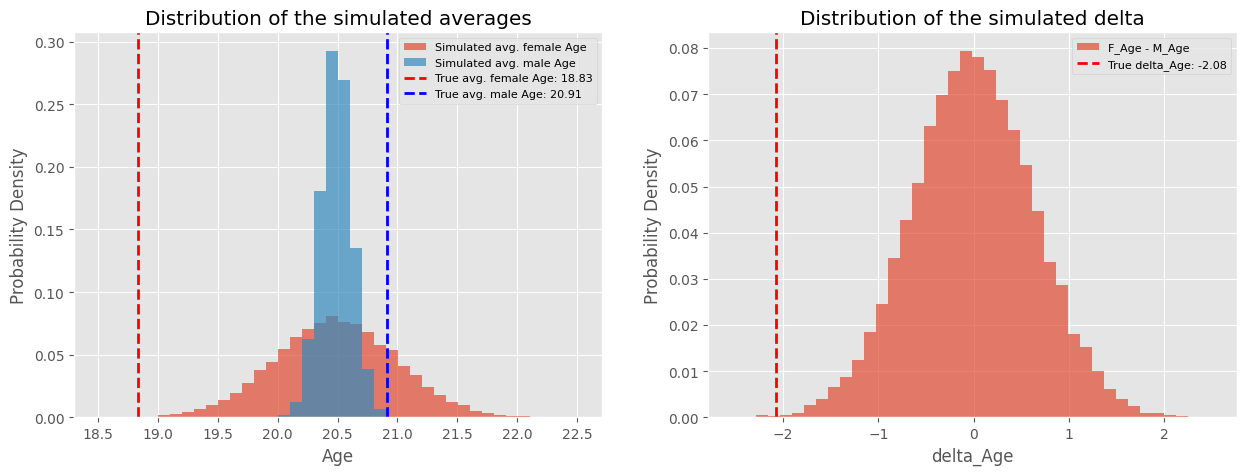

In [29]:
statistical_test(df_Invited,20000,'Age')

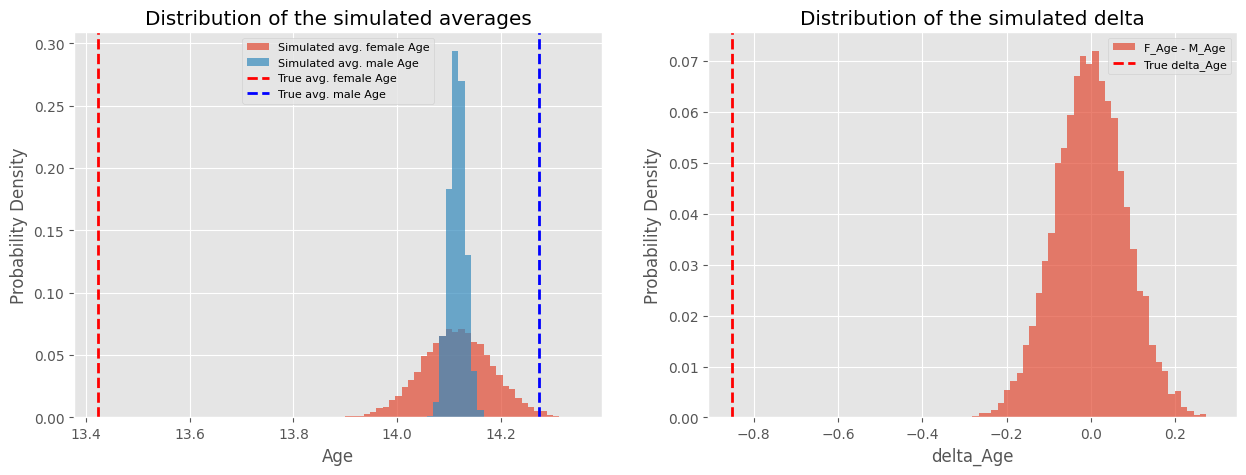

In [112]:
statistical_test(df_Proceedings,10000,'Age')

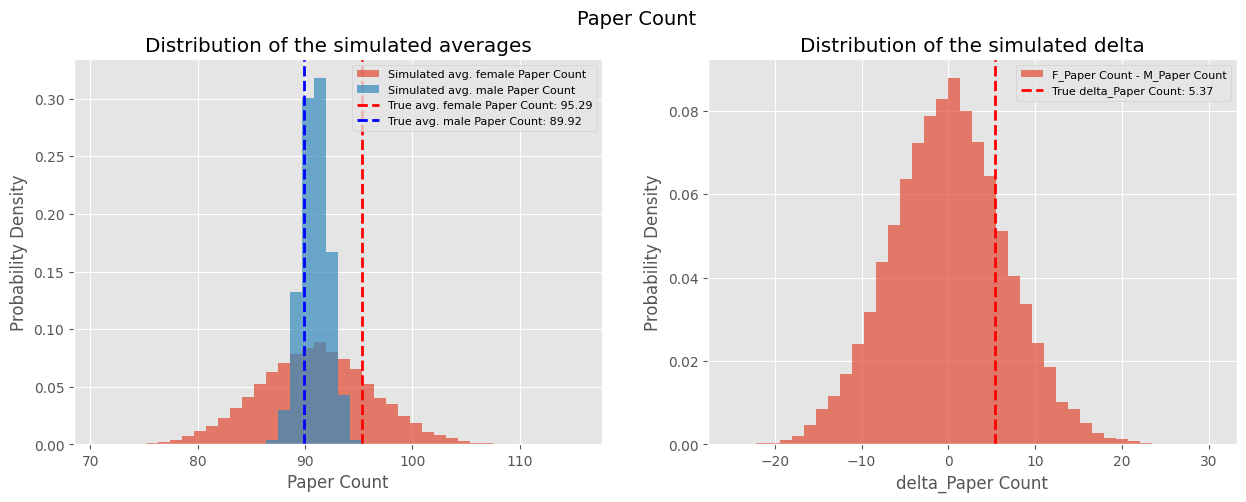

In [39]:
statistical_test(df_Invited,20000,'Paper Count')

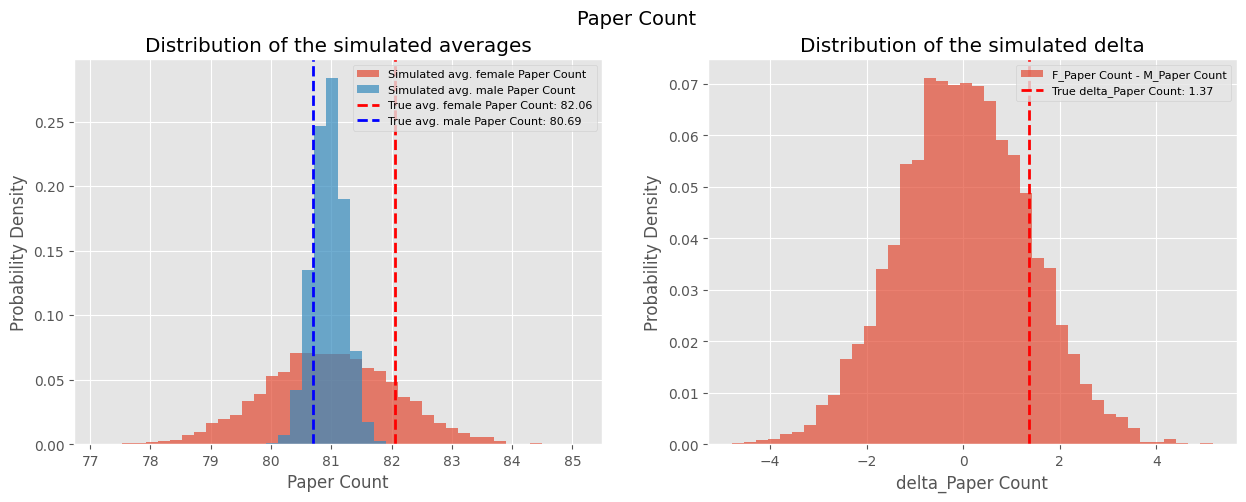

In [40]:
statistical_test(df_Proceedings,5000,'Paper Count')

## t-test

In [30]:
from scipy.stats import ttest_ind

# Split the data into two groups by gender
df_F = df_Invited[df_Invited['gender'] == 'F']
df_M = df_Invited[df_Invited['gender'] == 'M']

# Perform a t-test to compare the means of the age variable between the two groups
t_statistic, p_value = ttest_ind(df_F['Age'], df_M['Age'], equal_var=False)

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -2.9323705849993713
p-value: 0.0034904856445726056


There is a significant difference between the mean age of men and women. The t-statistics is negative, which means that women have lower average age than men.

In [32]:
t_statistic, p_value = ttest_ind(df_F['Paper Count'], df_M['Paper Count'], equal_var=False)

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 0.1799362644984473
p-value: 0.8572682020216723


The p-value is above 0.05, so we cannot reject the null hypothesis that the means of the two groups are equal.

## Ratio

In [8]:
# Drop all rows with 0 values
df_Invited = df_Invited[df_Invited['Age'] != 0]
df_Invited = df_Invited[df_Invited['Paper Count'] != 0]

# initialize the lists to store the averages
avg_age_F = []
avg_age_M = []
avg_paper_F = []
avg_paper_M = []

prop_F = len(df_Invited[df_Invited['gender'] == 'F']) / len(df_Invited)
prop_M = len(df_Invited[df_Invited['gender'] == 'M']) / len(df_Invited)

for i in range(10000):
    # randomly assign a new gender to each row
    df_Invited['gender'] = np.random.choice(['F', 'M'], size=len(df_Invited), p=[prop_F, prop_M])

    # calculate and store the average Value for each gender
    # use groupby instead!
    avg_age_F.append(df_Invited[df_Invited['gender'] == 'F']['Age'].median())
    avg_age_M.append(df_Invited[df_Invited['gender'] == 'M']['Age'].median())

    avg_paper_F.append(df_Invited[df_Invited['gender'] == 'F']['Paper Count'].median())
    avg_paper_M.append(df_Invited[df_Invited['gender'] == 'M']['Paper Count'].median())
    
ratio_F = [x / y for x, y in zip(avg_age_F, avg_paper_F)]
ratio_M = [x / y for x, y in zip(avg_age_M, avg_paper_M)]

bins=np.histogram(np.hstack((ratio_F,ratio_M)), bins=40)[1]

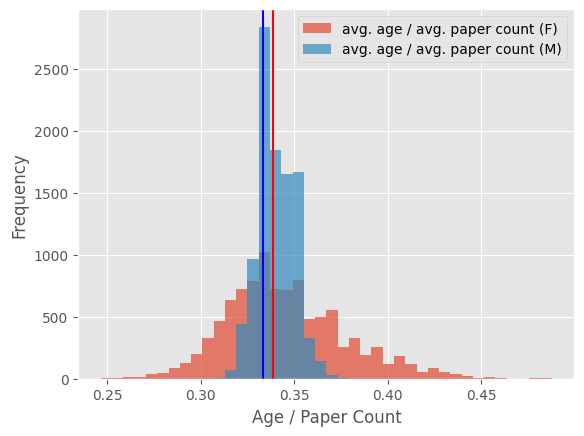

In [9]:
plt.hist(ratio_F, alpha=0.7, label="avg. age / avg. paper count (F)", bins=bins)
plt.hist(ratio_M, alpha=0.7, label="avg. age / avg. paper count (M)", bins=bins)
plt.axvline(df_Invited[df_Invited['gender'] == 'F']['Age'].median()/df_Invited[df_Invited['gender'] == 'F']['Paper Count'].median(), color = "red")
plt.axvline(df_Invited[df_Invited['gender'] == 'M']['Age'].median()/df_Invited[df_Invited['gender'] == 'M']['Paper Count'].median(), color = "blue")
plt.xlabel("Age / Paper Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()